# CSYE 7245

Kanika Nama- 001819073

Dinesh Deivamani- 001898851

# What is FbProphet?
Prophet is an open source library published by Facebook that is based on trend,seasonality and holidays models. It provides us with the ability to make time series predictions with good accuracy using simple intuitive parameters and has support for including impact of custom seasonality and holidays!

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/05/tumblr_inline_omh3tnv5zk1r1x9ql_500.png")

# What are we trying to do?

In this blog, we are trying to explain how we can predict stock prices using Fbprophet model to forecast the time series.

Before we proceed let's define basic model architecture which are to be known.

### The Prophet Forecasting Model
We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t)= g(t)+s(t)+h(t)+εt

g(t): piecewise linear or logistic growth curve for modelling non-periodic changes in time series

s(t): periodic changes (e.g. weekly/yearly seasonality)

h(t): effects of holidays (user provided) with irregular schedules

εt: error term accounts for any unusual changes not accommodated by the model

# Let's get started!

We still start off by obtaining the dataset which we are going to use.

The dataset has been obtained from https://www.yahoofinance.com/. The dataset consists of close prices for stocks of Amazon from 2016/01/01 to 2019/03/01 as an example to have better understanding about what we are doing. With yahoo.fin , we can access stock price easily. 

### The first step is to import all the required packages



In [53]:
# Importing Libraries
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf 
import pyspark as spark
from fbprophet import Prophet
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct
from pyspark.sql.types import FloatType, StructField, StructType, StringType, TimestampType
from sklearn.metrics import mean_squared_error

# Creating Spark session

In [54]:
spark = SparkSession.builder.getOrCreate()

**Get last 3 years of data from today**

In [55]:
start = datetime.now() # gets today's date
start = start.replace(year=start.year-3) # gets the date before 3 years
end = datetime.now() # gets today's date

# Importing dataset

**Get Amazon stock data from yahoo finance**

In [156]:
def get_csv():
    amzn_data = yf.download('AMZN',start,end) # getting amazon stock from yahoo finance
    amzn_data.to_csv('AMZN.csv', index=True, header=True)
    amzn_data.Close.plot() # Plotting the close value of stocks
    plt.show()
    return;

[*********************100%***********************]  1 of 1 downloaded


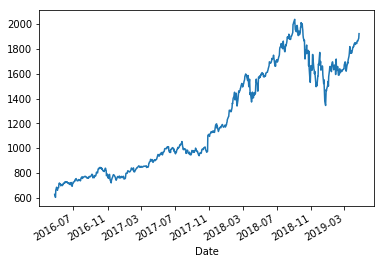

In [157]:
get_csv()

**Creating Spark DataFrame**

In [158]:
df = (spark.read
          .option("header", "true")
          .option("inferSchema", value=True)
          .csv("AMZN.csv"))

In [59]:
df.head(5)

[Row(Date=datetime.datetime(2016, 1, 4, 0, 0), High=657.719970703125, Low=627.510009765625, Open=656.2899780273438, Close=636.989990234375, Volume=9314500, Adj Close=636.989990234375),
 Row(Date=datetime.datetime(2016, 1, 5, 0, 0), High=646.9099731445312, Low=627.6500244140625, Open=646.8599853515625, Close=633.7899780273438, Volume=5822600, Adj Close=633.7899780273438),
 Row(Date=datetime.datetime(2016, 1, 6, 0, 0), High=639.7899780273438, Low=620.3099975585938, Open=622.0, Close=632.6500244140625, Volume=5329200, Adj Close=632.6500244140625),
 Row(Date=datetime.datetime(2016, 1, 7, 0, 0), High=630.0, Low=605.2100219726562, Open=621.7999877929688, Close=607.9400024414062, Volume=7074900, Adj Close=607.9400024414062),
 Row(Date=datetime.datetime(2016, 1, 8, 0, 0), High=624.1400146484375, Low=606.0, Open=619.6599731445312, Close=607.0499877929688, Volume=5512900, Adj Close=607.0499877929688)]

# Assign ds & y values

In [60]:
data = df.select(
        df['date'].alias('ds'),
        df['Close'].cast(FloatType()).alias('y')
    )

In [62]:
data.head(5)

[Row(ds=datetime.datetime(2016, 1, 4, 0, 0), y=636.989990234375),
 Row(ds=datetime.datetime(2016, 1, 5, 0, 0), y=633.7899780273438),
 Row(ds=datetime.datetime(2016, 1, 6, 0, 0), y=632.6500244140625),
 Row(ds=datetime.datetime(2016, 1, 7, 0, 0), y=607.9400024414062),
 Row(ds=datetime.datetime(2016, 1, 8, 0, 0), y=607.0499877929688)]

In [63]:
data.select(data.ds, data.y).show()

+-------------------+------+
|                 ds|     y|
+-------------------+------+
|2016-01-04 00:00:00|636.99|
|2016-01-05 00:00:00|633.79|
|2016-01-06 00:00:00|632.65|
|2016-01-07 00:00:00|607.94|
|2016-01-08 00:00:00|607.05|
|2016-01-11 00:00:00|617.74|
|2016-01-12 00:00:00|617.89|
|2016-01-13 00:00:00|581.81|
|2016-01-14 00:00:00| 593.0|
|2016-01-15 00:00:00|570.18|
|2016-01-19 00:00:00|574.48|
|2016-01-20 00:00:00|571.77|
|2016-01-21 00:00:00|575.02|
|2016-01-22 00:00:00|596.38|
|2016-01-25 00:00:00|596.53|
|2016-01-26 00:00:00|601.25|
|2016-01-27 00:00:00|583.35|
|2016-01-28 00:00:00|635.35|
|2016-01-29 00:00:00| 587.0|
|2016-02-01 00:00:00|574.81|
+-------------------+------+
only showing top 20 rows



In [64]:
data = data.toPandas()

In [65]:
data.index = data.ds

In [66]:
data.tail(6)

,ds,y
ds,,
2019-04-15,2019-04-15,1844.869995
2019-04-16,2019-04-16,1863.040039
2019-04-17,2019-04-17,1864.819946
2019-04-18,2019-04-18,1861.689941
2019-04-22,2019-04-22,1887.310059
2019-04-23,2019-04-23,1904.020142


In [145]:
length = len(data)

In [147]:
train = data[0:length-7]

In [149]:
train.head()

,ds,y
ds,,
2019-04-05,2019-04-05,1837.280029
2019-04-08,2019-04-08,1849.859985
2019-04-09,2019-04-09,1835.839966
2019-04-10,2019-04-10,1847.329956
2019-04-11,2019-04-11,1844.069946


## Creating and Fitting the FB Prophet model

### Trend

Trend is modelled by fitting a piece wise linear curve over the trend or the non-periodic part of the time series. The linear fitting exercise ensures that it is least affected by spikes/missing data.

### Seasonalities

The different seasonalities are yearly_seasonality, weekly_seasonality & daily_seasonality and they can take values as True, False.The fourier order N that defines whether high frequency changes are allowed to be modelled is an important parameter to set here. For a time series, if the user believes the high frequency components are just noise and should not be considered for modelling, he/she could set the values of N from to a lower value. If not, N can be tuned to a higher value and set using the forecast accuracy. If the value is True, default number of fourier terms (10) are taken. Prior scales are defined to tell the model how strongly it needs to consider the seasonal/holiday components while fitting and forecasting.

In [150]:
model = Prophet(yearly_seasonality = True, weekly_seasonality= False, seasonality_prior_scale=0.1) # Defining the model
model.fit(train) # fit data to model
future = model.make_future_dataframe(periods=7)#it creates  rows 
forecast = model.predict(future)

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [69]:
forecast.shape

(838, 16)

We can look at the various components using the following command:

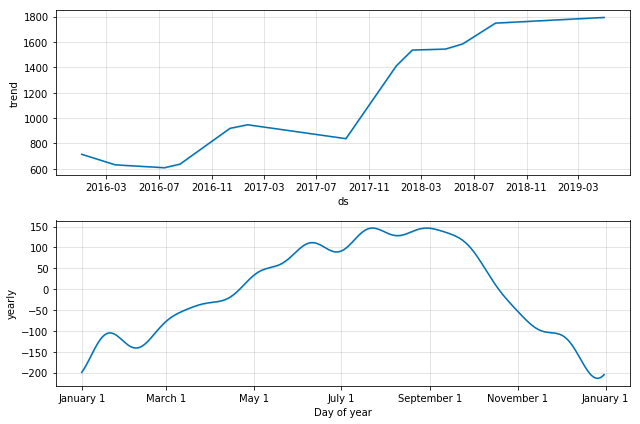

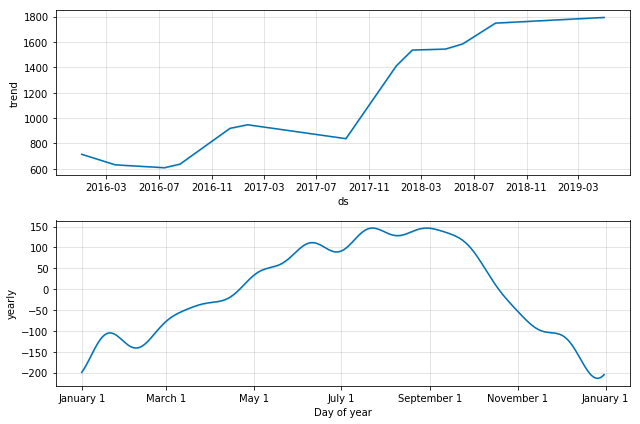

In [70]:
model.plot_components(forecast) # Display different components

### Holidays and events

Holidays and events incur predictable shocks to a time series. For instance, Prime Day occurs once in every year and a large portion of the population buy a lot of items during this period. So, the sales will increase for Amazon.

### Let's add holidays and events to our model 

We are adding Long weekends and Amazon Prime days to the model

In [71]:
# Defining Amazon prime days
primedays = pd.DataFrame({
               'holiday':'primeday', 
               'ds' : pd.to_datetime(['2016-06-12', '2017-06-10','2018-06-20']),
               'lower_window': -1,
               'upper_window': 1,
})

In [72]:
# Defining Long weekends
longweekends = pd.DataFrame({
               'holiday':'longweekend', 
               'ds' : pd.to_datetime(['2016-05-10', '2017-03-15','2018-04-21']),  
               'lower_window': -1,
               'upper_window': 1,
})

In [73]:
primedays

,holiday,ds,lower_window,upper_window
0,primeday,2016-06-12,-1,1
1,primeday,2017-06-10,-1,1
2,primeday,2018-06-20,-1,1


**Combining both prime and long weekend in to holidays dataframe**

In [74]:
holidays = pd.concat((primedays, longweekends))

In [75]:
holidays.index = holidays['ds']

In [76]:
holidays

,holiday,ds,lower_window,upper_window
ds,,,,
2016-06-12,primeday,2016-06-12,-1,1
2017-06-10,primeday,2017-06-10,-1,1
2018-06-20,primeday,2018-06-20,-1,1
2016-05-10,longweekend,2016-05-10,-1,1
2017-03-15,longweekend,2017-03-15,-1,1
2018-04-21,longweekend,2018-04-21,-1,1


### Fit the model with holidays

In [151]:
m = Prophet(yearly_seasonality = True,holidays= holidays) # Creating the model
m.fit(train) # fit data to model
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future)

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [78]:
forecast.shape

(838, 28)

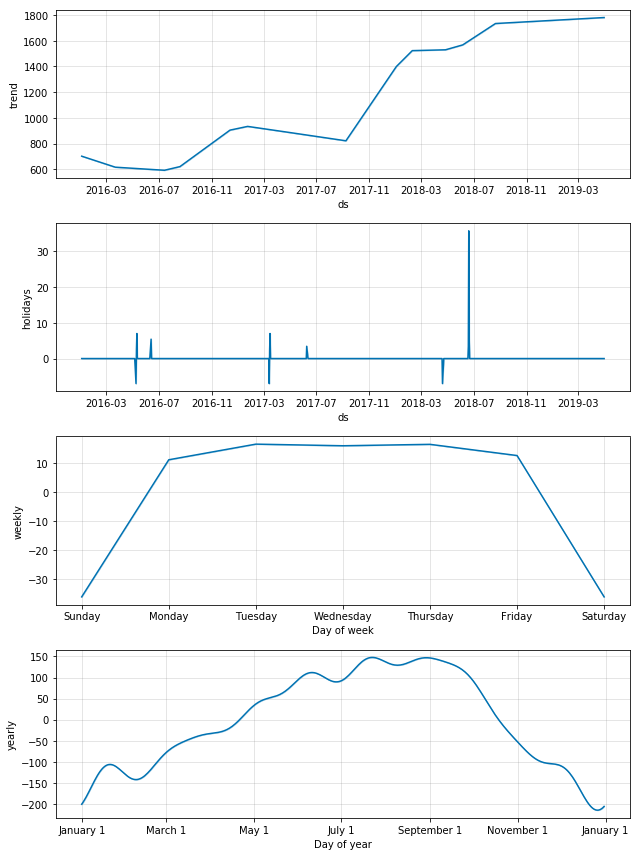

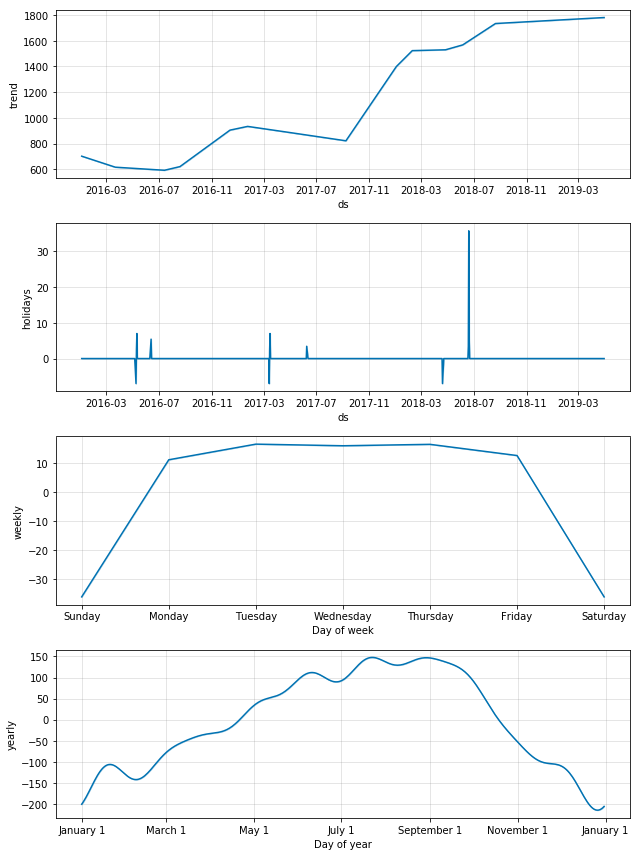

In [79]:
m.plot_components(forecast) # displays the different components

### Forecasting values for next 7 days 

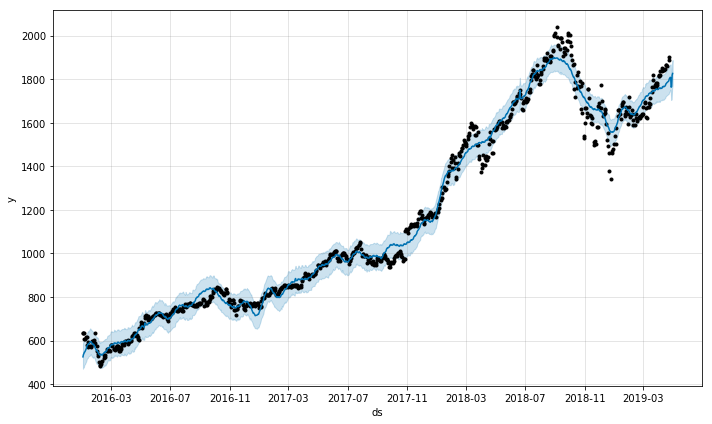

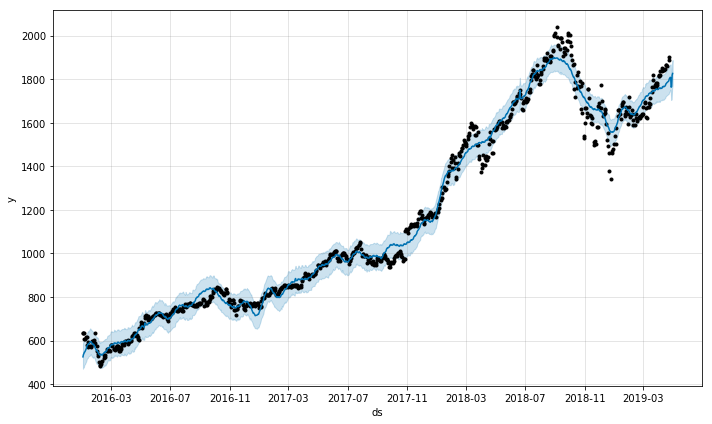

In [80]:
m.plot(forecast)

## Tuning Hyperparameters

**Trend parameters**

* growth -	linear’ or ‘logistic’ to specify a linear or logistic trend
* changepoints - List of dates at which to include potential changepoints (automatic if not specified)
* n_changepoints -	If changepoints in not supplied, you may provide the number of changepoints to be automatically included
* changepoint_prior_scale -	Parameter for changing flexibility of automatic changepoint selection

**Seasonality & Holiday Parameters**

* yearly_seasonality -	Fit yearly seasonality
* weekly_seasonality -	Fit weekly seasonality
* daily_seasonality -	Fit daily seasonality
* holidays -	Feed dataframe containing holiday name and date
* seasonality_prior_scale -	Parameter for changing strength of seasonality model
* holiday_prior_scale -	Parameter for changing strength of holiday model

#### 1. n_changepoints = 5, changepoint_prior_scale = 0.05, seasonality_prior_scale=0.95, fourier_order=20

In [152]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.95, 
            changepoint_prior_scale=0.05, n_changepoints=5,
            holidays= holidays) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=20)
m.add_country_holidays(country_name='US')
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


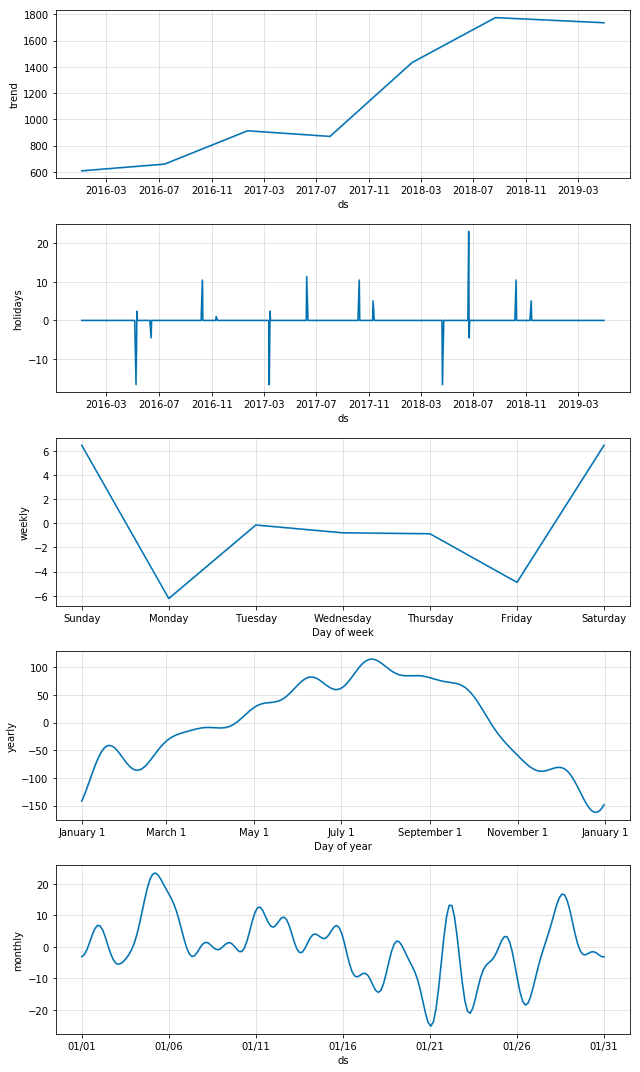

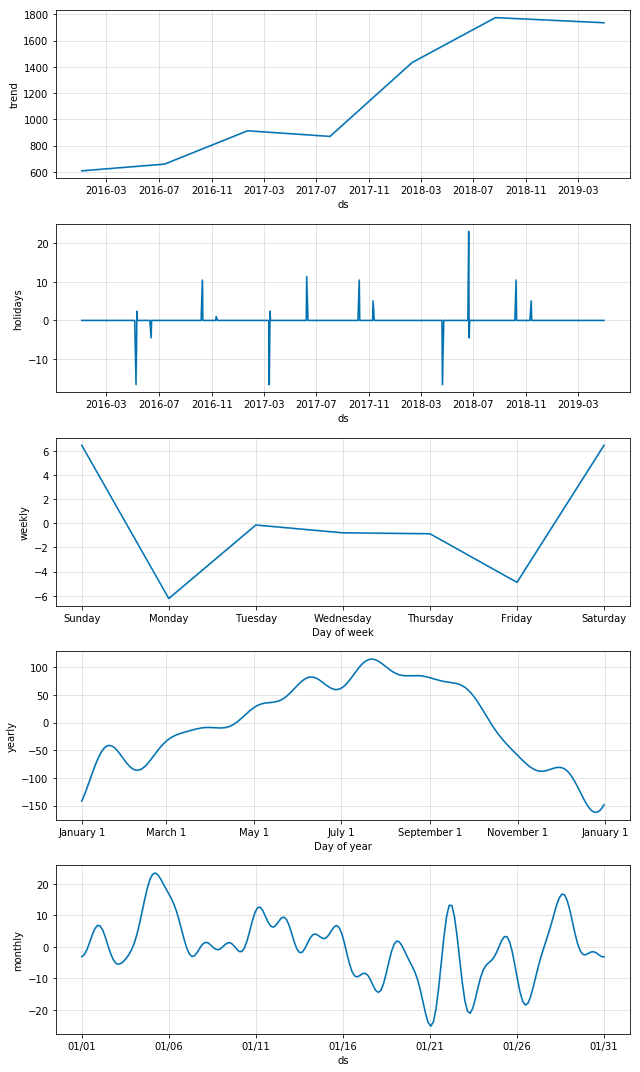

In [31]:
m.plot_components(forecast) # displays the different components

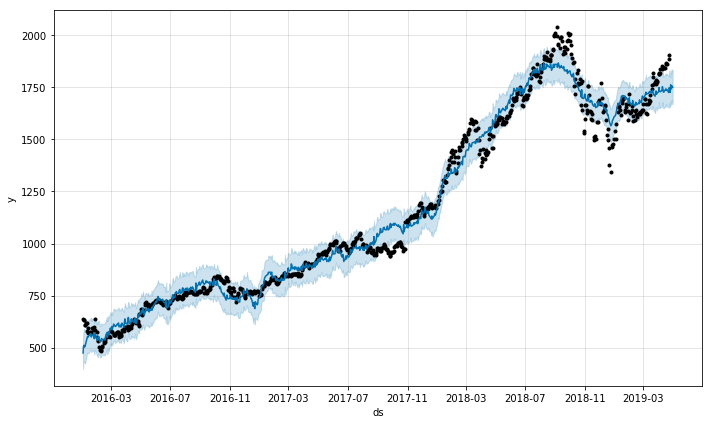

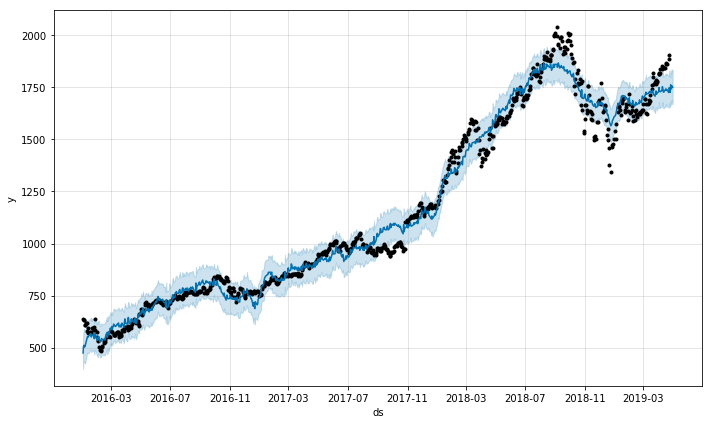

In [32]:
m.plot(forecast)

#### 2. n_changepoints = 9, changepoint_prior_scale = 0.05, seasonality_prior_scale=0.95, fourier_order=20

In [153]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.95, 
            changepoint_prior_scale=0.05, n_changepoints=9, #changepoints=['2019-01-01'], 
            holidays= holidays) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=20)
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


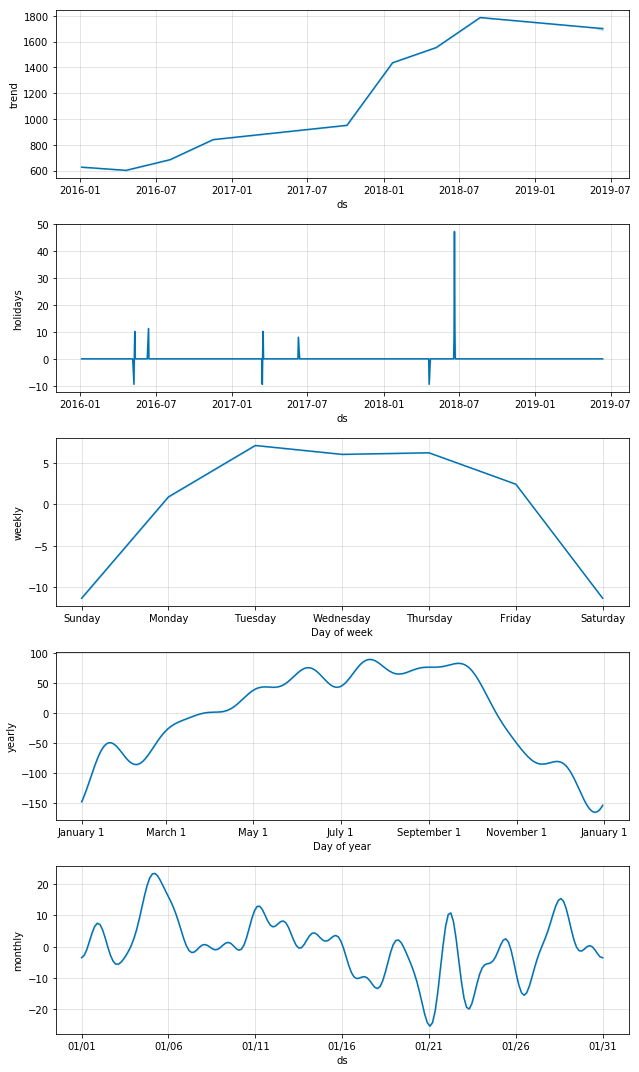

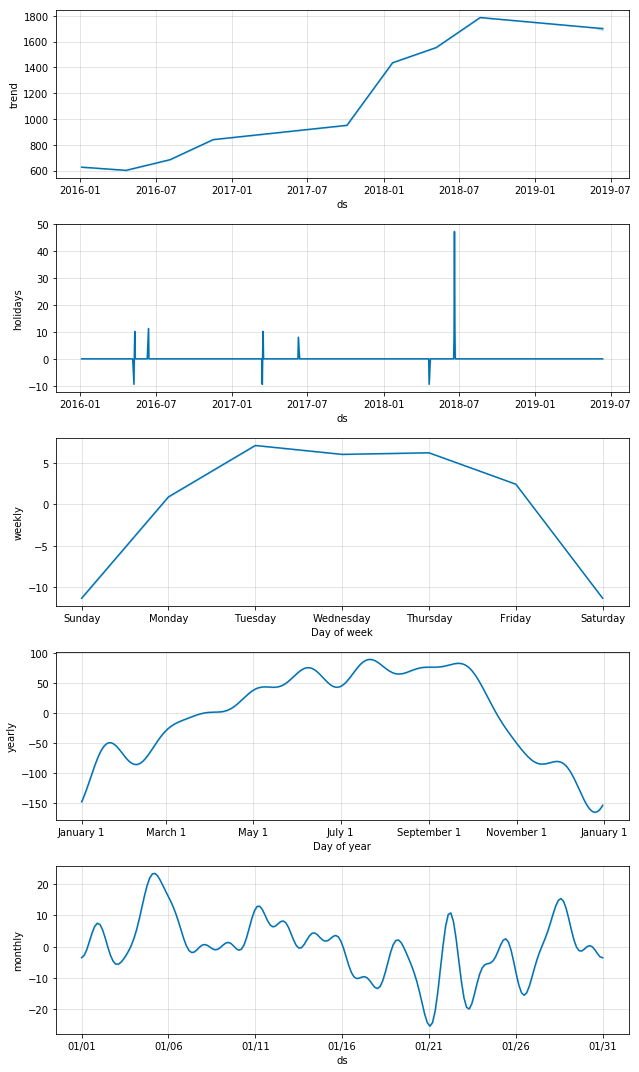

In [34]:
m.plot_components(forecast) # displays the different components

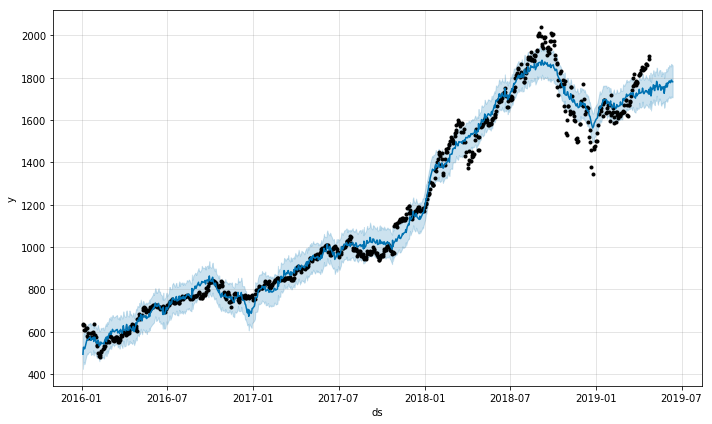

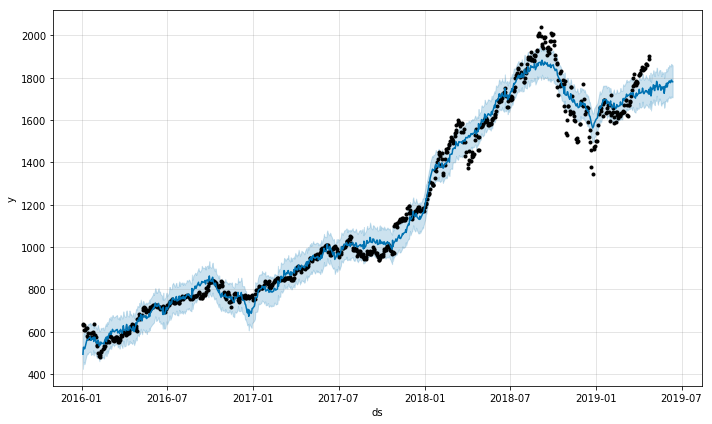

In [35]:
m.plot(forecast)

#### 3. n_changepoints = 9, changepoint_prior_scale = 0.1, seasonality_prior_scale=0.95, fourier_order=20

In [154]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.95, 
            changepoint_prior_scale=0.1, n_changepoints=9, #changepoints=['2019-01-01'], 
            holidays= holidays) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=20)
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


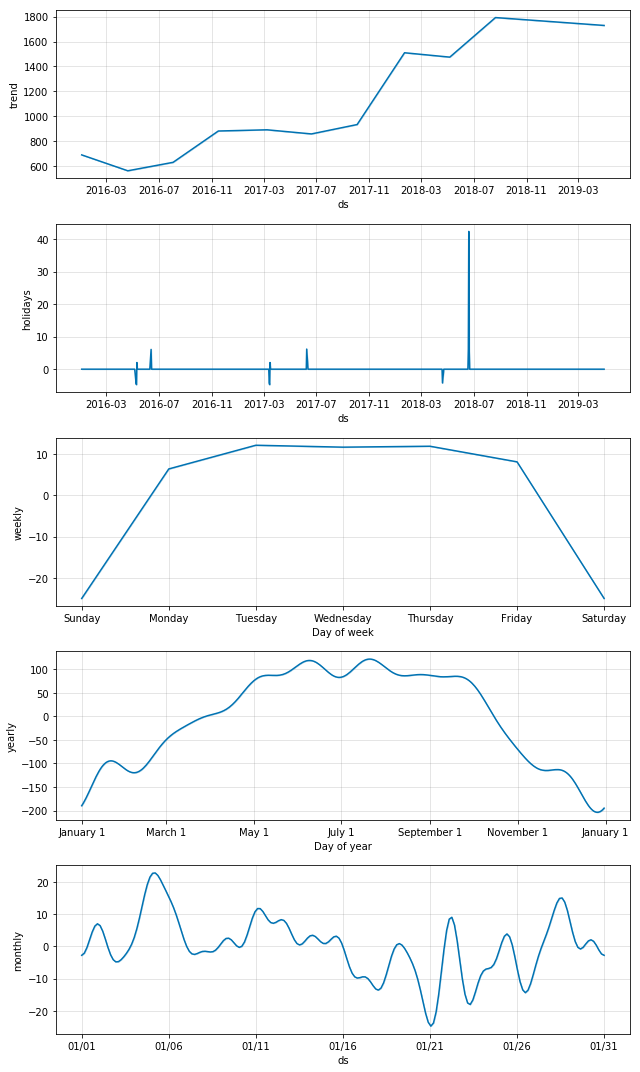

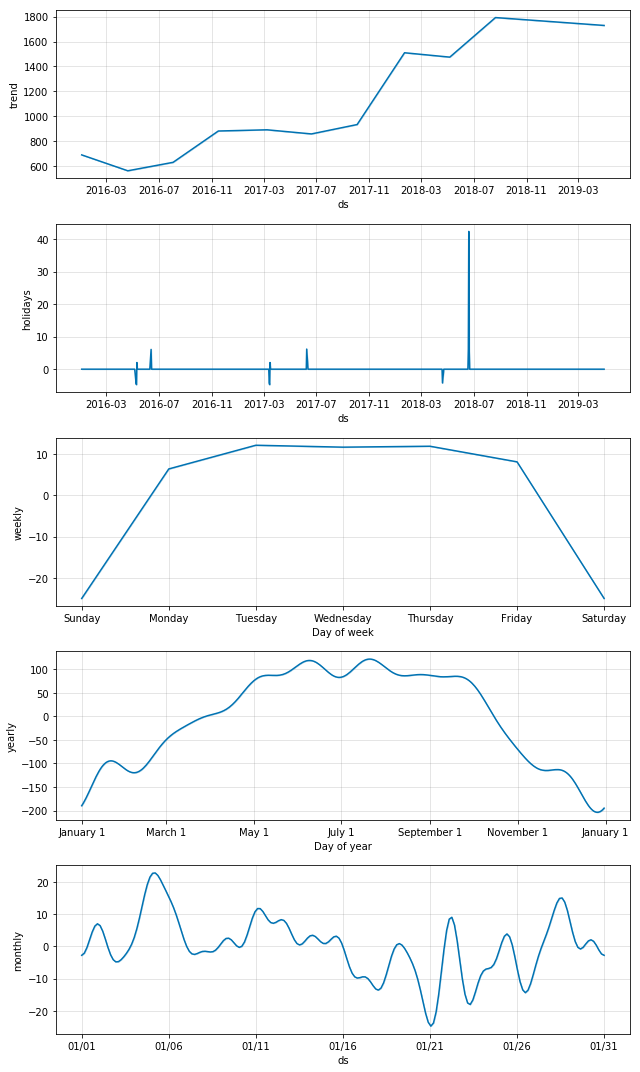

In [37]:
m.plot_components(forecast) # displays the different components

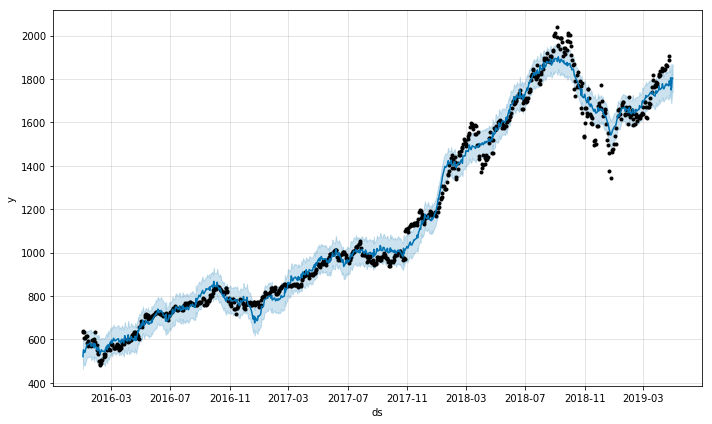

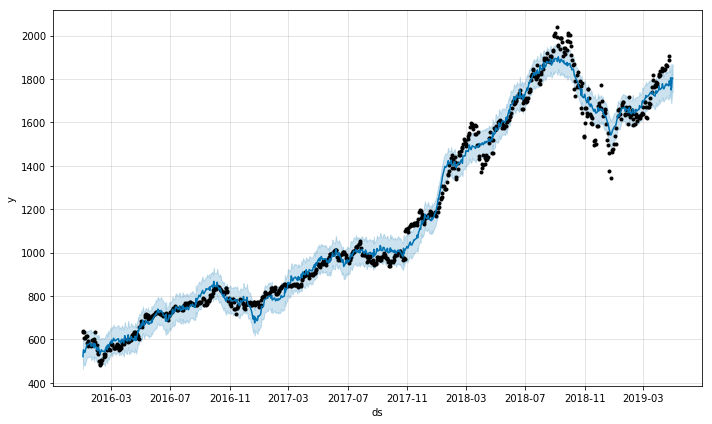

In [38]:
m.plot(forecast)

#### 4. n_changepoints = 15, changepoint_prior_scale = 1.0, seasonality_prior_scale=0.5, fourier_order=13

In [155]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.5, 
            changepoint_prior_scale=1.0, n_changepoints=15, #changepoints=['2019-01-01'], 
            holidays= holidays
           ) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=13)
m.add_country_holidays(country_name='US')
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [104]:
#forecast

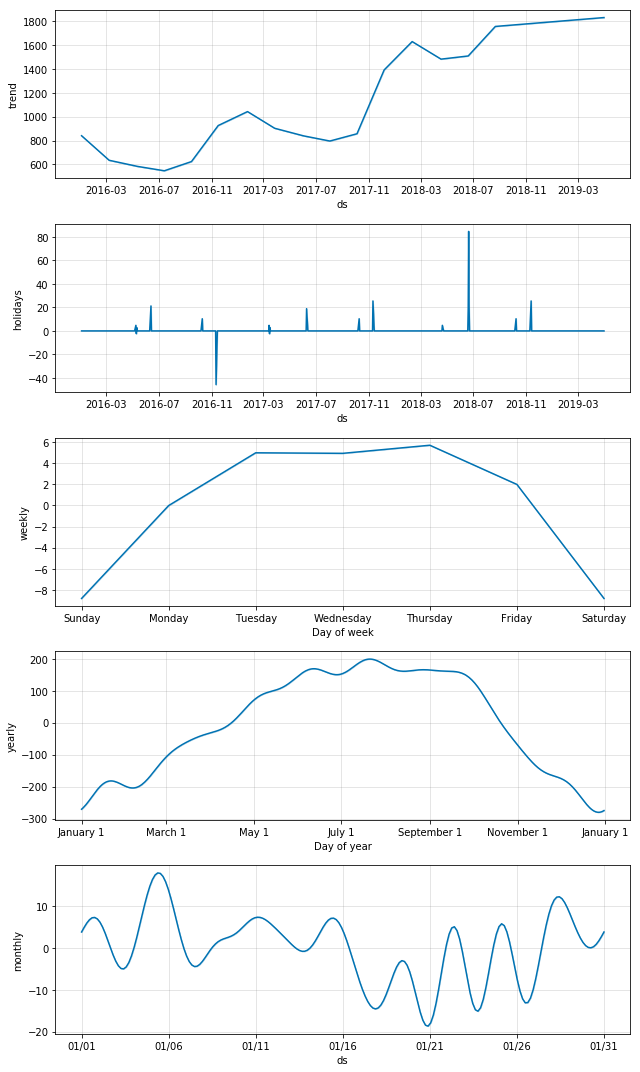

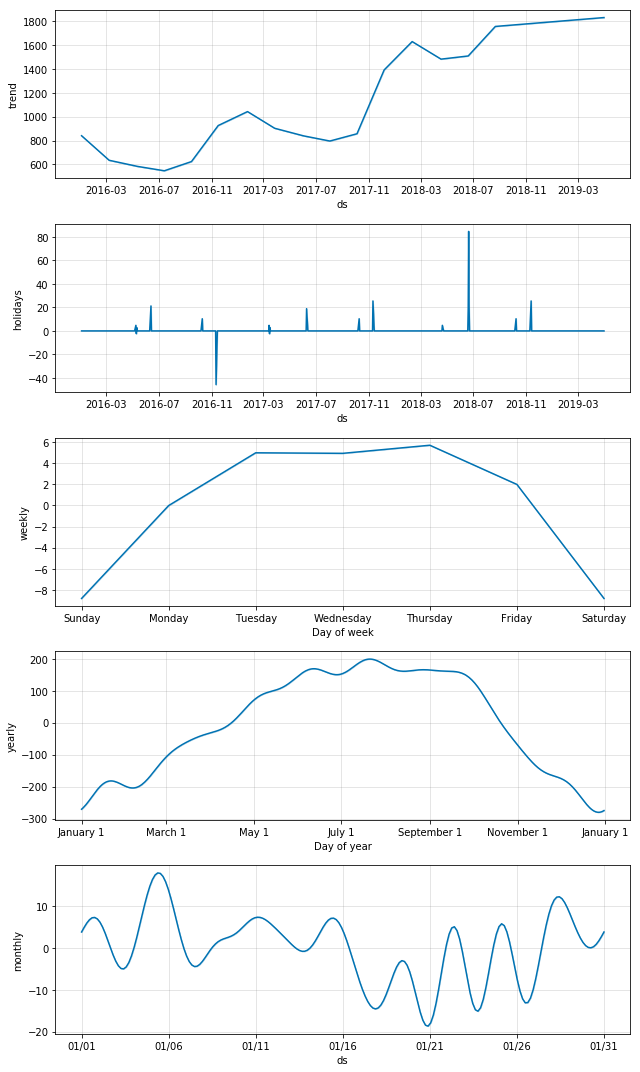

In [105]:
m.plot_components(forecast) # displays the different components

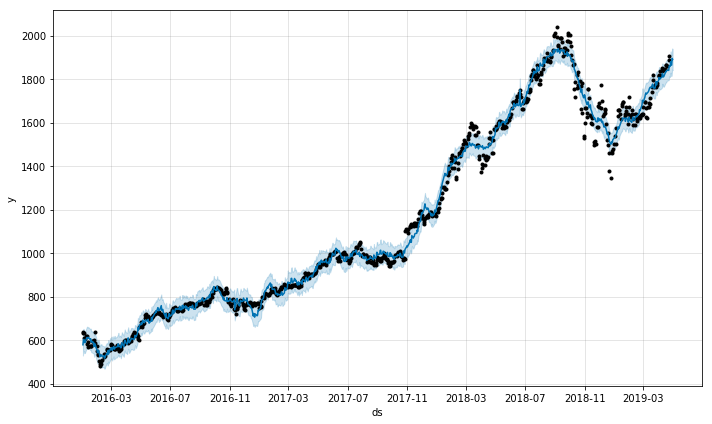

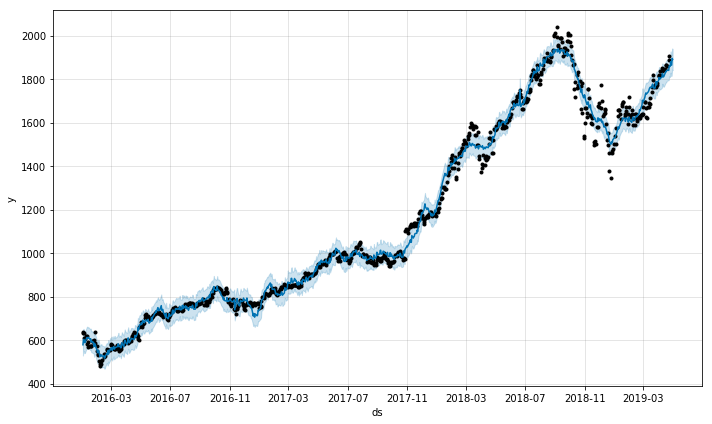

In [106]:
m.plot(forecast)

In [108]:
length = len(data)

In [109]:
forecast['yhat'][length-7:length]

824    1812.703045
825    1828.720250
826    1834.405924
827    1834.525829
828    1840.498678
829    1840.069095
830    1860.045942
Name: yhat, dtype: float64

So, the following parameters give better forecast for different components:

**n_changepoints = 15, changepoint_prior_scale = 1.0, seasonality_prior_scale=0.5, fourier_order=13**

## Function for FB Prophet Model with best parameters

In [159]:
def fb(i):
    length = len(data)
    train = data[0:length-i]
    m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.1, 
            changepoint_prior_scale=0.95, n_changepoints=23, #changepoints=['2019-01-01'], 
            holidays= holidays
           ) # Creating the model 
    m.add_seasonality('monthly',period=30.5,fourier_order=15)
    m.add_country_holidays(country_name='US')
    m.fit(train) # fit data to model 
    future = m.make_future_dataframe(periods=i)#it creates  rows 
    forecast = m.predict(future) 
    m.plot(forecast)
    #p_length = len(forecast)
    #a_length = len(data)
    #s_length = length-i
    prediction = forecast['yhat'][length-i:length] #Get values till today
    test = data[length-i:length]
    prediction.index = test.index #set common index
    result = pd.concat([prediction, test.y], axis=1, ignore_index=False) #Concatinate actual and predicted
    result['date'] = result.index
    result.to_csv('out.csv', index=True, header=True) # export to csv
    print (result)
    return result;

C:\Users\Dt\Anaconda3\lib\site-packages\fbprophet\forecaster.py:250: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


                   yhat            y       date
ds                                             
2019-04-12  1840.328059  1843.060059 2019-04-12
2019-04-15  1854.135066  1844.869995 2019-04-15
2019-04-16  1862.504593  1863.040039 2019-04-16
2019-04-17  1862.902522  1864.819946 2019-04-17
2019-04-18  1870.477487  1861.689941 2019-04-18
2019-04-22  1881.341321  1887.310059 2019-04-22
2019-04-23  1884.885198  1904.020142 2019-04-23


,yhat,y,date
ds,,,
2019-04-12,1840.328059,1843.060059,2019-04-12
2019-04-15,1854.135066,1844.869995,2019-04-15
2019-04-16,1862.504593,1863.040039,2019-04-16
2019-04-17,1862.902522,1864.819946,2019-04-17
2019-04-18,1870.477487,1861.689941,2019-04-18
2019-04-22,1881.341321,1887.310059,2019-04-22
2019-04-23,1884.885198,1904.020142,2019-04-23


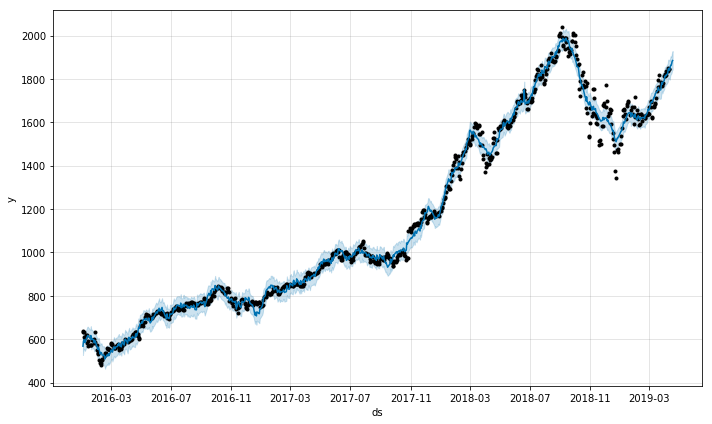

In [160]:
fb(7)

# Cross Validation

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

Here we do cross-validation to assess prediction performance on a horizon of 60 days, starting with 350 days of training data in the first cutoff and then making predictions every 30 days.

In [139]:
from fbprophet.diagnostics import cross_validation

In [140]:
data_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 27 forecasts with cutoffs between 2017-01-03 00:00:00 and 2019-02-22 00:00:00
C:\Users\Dt\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat

# Obtaining the Performance Metrics

In [141]:
from fbprophet.diagnostics import performance_metrics

In [142]:
data_p = performance_metrics(data_cv)
data_p.head()

,horizon,mse,rmse,mae,mape,coverage
128,7 days,5202.346849,72.127296,47.533108,0.035233,0.342342
45,7 days,5226.322570,72.293309,47.990197,0.035789,0.333333
420,7 days,5251.406851,72.466591,48.378168,0.036165,0.324324
500,7 days,5245.612608,72.426602,48.304951,0.036188,0.315315
707,7 days,5250.609425,72.461089,48.411493,0.036178,0.324324


In [143]:
data_p

,horizon,mse,rmse,mae,mape,coverage
128,7 days,5202.346849,72.127296,47.533108,0.035233,0.342342
45,7 days,5226.322570,72.293309,47.990197,0.035789,0.333333
420,7 days,5251.406851,72.466591,48.378168,0.036165,0.324324
500,7 days,5245.612608,72.426602,48.304951,0.036188,0.315315
707,7 days,5250.609425,72.461089,48.411493,0.036178,0.324324
995,7 days,5247.645655,72.440635,48.279348,0.036091,0.324324
336,7 days,5247.574128,72.440142,48.278224,0.036180,0.324324
917,7 days,5455.295430,73.859972,49.412203,0.036698,0.324324
295,7 days,5466.208801,73.933814,49.631310,0.036964,0.315315
462,7 days,5272.455036,72.611673,48.889711,0.036721,0.315315


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). 

# Visualizing Performance Metrics

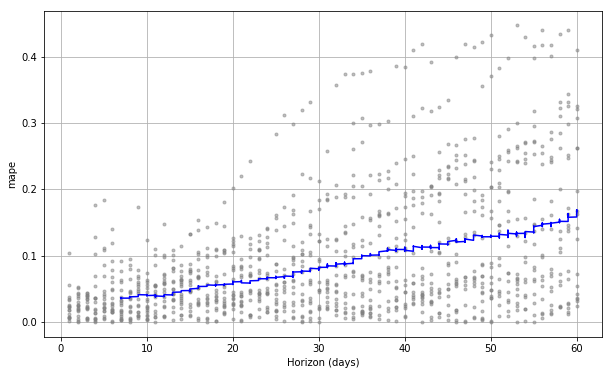

In [144]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(data_cv, metric='mape')

The performance Metrics can be visualized using the plot_cross_validation_metric utility. We visualize the RMSE as shown in the graph.As we have seen Prophet is very powerful and effective in time series forecasting and have given the best predictions with the least amount of errors.Dots show the absolute percent error for each prediction in data_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 10% are typical for predictions one month into the future, and that errors increase up to around 25% for predictions that are a year out.

# Contribution

-Tuning of hyperparameters of Fbprophet

-Defining different seasonalities for our model with respect to our data

-Spark implementation for data loading and eda

-Implementing the code on Databricks

-Implementing the code on Google cloud platform

# Conclusion
 
1.We created the FB Prophet model including the required seasonalities for our timeseries data.

2.Holiday parameters are included which contains long weekend holidays and Prime days for our Amazon stocks as they can have an impact on the company's sales. 

3.We have tuned different hyperparamters of different components and chose the set of parameters that gave better reults for every component. Later we exported the predicted vs actual data in a csv file for comparison. 

4.Also, we performed cross validation using performance_metrics which gave mse, rmse, mae, mape values. 

5.We used mape value to check the performance of our model and we got approximately 0.08% error for a horrizon of 30 days.

6.We have achieved an approximate accuracy of 96.5% for the dataset on our created model. 

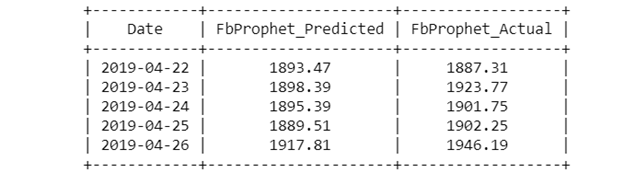

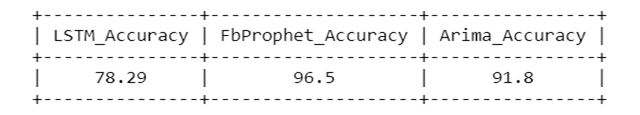

# References

1.Asidlo.“Asidlo/Sparkprophet.” GitHub, github.com/asidlo/sparkprophet/blob/master/sparkprophet.py.

2.Facebook.github.io, facebook.github.io/prophet/docs/.

3.Choudhary, Ankit, and IIT Bombay Graduate. “Time Series Forecasts Using Facebook's Prophet (with Python & R Codes).” Analytics Vidhya, 20 Sept. 2018, www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/.

4.“Powerful Python Data Analysis Toolkit¶.” Pandas, pandas.pydata.org/pandas-docs/stable/.

5.“KDnuggets.” KDnuggets Analytics Big Data Data Mining and Data Science, www.kdnuggets.com/2018/11/sales-forecasting-using-prophet.html.

6.Peerj.com. (2019). [online] Available at: https://peerj.com/preprints/3190.pdf [Accessed 27 Apr. 2019].
        
7.Towards Data Science. (2019). Predicting the ‘Future’ with Facebook’s Prophet. [online] Available at: https://towardsdatascience.com/predicting-the-future-with-facebook-s-prophet-bdfe11af10ff [Accessed 27 Apr. 2019].


# Licenses

Copyright 2019 Kanika Nama Dinesh Deivamani

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

THE WORK (AS DEFINED BELOW) IS PROVIDED UNDER THE TERMS OF THIS CREATIVE COMMONS PUBLIC LICENSE ("CCPL" OR "LICENSE"). THE WORK IS PROTECTED BY COPYRIGHT AND/OR OTHER APPLICABLE LAW. ANY USE OF THE WORK OTHER THAN AS AUTHORIZED UNDER THIS LICENSE OR COPYRIGHT LAW IS PROHIBITED.

BY EXERCISING ANY RIGHTS TO THE WORK PROVIDED HERE, YOU ACCEPT AND AGREE TO BE BOUND BY THE TERMS OF THIS LICENSE. TO THE EXTENT THIS LICENSE MAY BE CONSIDERED TO BE A CONTRACT, THE LICENSOR GRANTS YOU THE RIGHTS CONTAINED HERE IN CONSIDERATION OF YOUR ACCEPTANCE OF SUCH TERMS AND CONDITIONS.